# Preprocessing

* Code by Caroline Juang, c.juang@columbia.edu
* For Machine Learning for the Environmental Sciences, Columbia University
* Professor: Pierre Gentine
* November 2021 - December 2021

### Download Data

Downloading data from box is tricky, here's the URL for the data download.

Data is created by Park Williams, from various sources. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136851087076)

Fire data is created by Caroline Juang and Park Williams, from the Monitoring Trends in Burn Severity (MTBS) product and government agency databases. Use the `burnarea_combined.nc` file. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136850119129)

### Workspace Setup

* import variables
* forest burned area

In [1]:
# import
import numpy as np
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt

### Ecoregions
* 10.1 Cold deserts
* 7.1 Marine west coast forest
* 11.1 Mediterranean California
* 9.4 South Central Semiarid Prairies
* 9.2 Temperate Prairies (not included)
* 13.1 Upper Gila Mountains
* 10.2 Warm Deserts
* 9.3 West-Central Semiarid Prairies
* 6.2 Western Cordillera
* 12.1 Western Sierra Madre Piedmont

In [2]:
## open the ecoregion data
ecoregion_data = xr.open_dataset('C:\\Users\\carol\\Documents\\Research Data 2020\\12km\\landcover\\Ecoregions_EPA\\epa_level2.nc')
# drop the bad ecoregion
ecoregion_data = ecoregion_data.sel(province=[0,1,2,3,5,6,7,8,9], drop=True)

ecoregion_legend = ecoregion_data.ecoregion
print(ecoregion_legend.legend)
epa_l2 = ecoregion_data.epa_level2
ecoregion_data = None

1: COLD DESERTS, 2: MARINE WEST COAST FOREST, 3: MEDITERRANEAN CALIFORNIA, 4: SOUTH CENTRAL SEMIARID PRAIRIES, 5: TEMPERATE PRAIRIES, 6: UPPER GILA MOUNTAINS, 7: WARM DESERTS, 8: WEST-CENTRAL SEMIARID PRAIRIES, 9: WESTERN CORDILLERA, 10: WESTERN SIERRA MADRE PIEDMONT


In [3]:
# setup forested area burned

# forest fractional area (Ruefenacht et al., 2018)
forest_type_data = xr.open_dataset('C:\\Users\\carol\\Documents\\Research Data 2020\\12km\\landcover\\US_ForestType_Ruefenacht\\forest_type_frac.nc')

# fire burned area (Williams and Juang)
burnarea_data = xr.open_dataset('C:\\Users\\carol\\Documents\\Research Data 2020\\12km\\wildfire\\burnarea_combined.nc', engine='netcdf4')
time_str = burnarea_data.time
X = burnarea_data.X
Y = burnarea_data.Y
burnarea_data = burnarea_data.rio.set_spatial_dims(x_dim='X', y_dim='Y', inplace=True)
burn = burnarea_data.burnarea

# get forest burned area (forest fraction x burned area)

# storage
forest = np.zeros((len(Y), len(X)), np.single)
# add up the forest percentages for each forest type
forest = forest_type_data.sum(dim='ftype').forest_type_frac
burnarea = burn*forest.values # result

# constrain time to 2019 (last year of fully-known data)
burnarea = burnarea.loc["1984-01-15":"2019-12-15"]

# Initial investigations

Some interesting ways to look at fire return rate

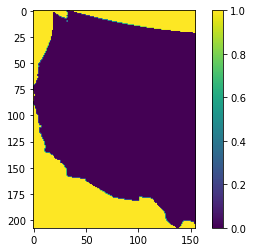

In [34]:
# storage
time = burnarea.time
X = burnarea_data.X
Y = burnarea_data.Y

# get the NaN values in a mask
maskUS = np.isnan(burnarea.isel(time=0))
fig, ax = plt.subplots()
this = ax.imshow(maskUS)
fig.colorbar(this)

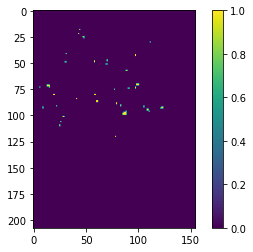

In [75]:
burnyes_month = (burnarea>0).astype(int)

fig, ax = plt.subplots()
this = ax.imshow(burnyes_month.sel(time="2018-09-15"))
fig.colorbar(this)

#fig, ax = plt.subplots()
#ax.hist(burnyes_month.sel(time="2018-08-15"))

In [69]:
burnyes_yr = burnarea.resample(indexer={'time':'Y'}).sum(skipna=True)

In [42]:
time1 = "2018-08-15"
time2 = "2018-09-15"

burnyes_month.sel(time=time1) + burnyes_month.sel(time=time2)


<xarray.DataArray 'burnarea' (Y: 208, X: 155)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05

In [13]:
# iterate through to find months since last fire burned

# storage
time = burnarea.time
X = burnarea_data.X
Y = burnarea_data.Y
return_months = np.zeros((len(time), len(Y), len(X))) # initialize
# tmp_past = np.zeros((len(X), len(Y), np.single)) # memory from previous month
month = burnarea.time[0]
tmp_past = 1*((burnarea.loc[month]==0) & (~np.isnan(burnarea.loc[month]))) # memory from first month, areas that did not burn
return_months[0] = tmp_past # store memory for first

# iterate
index = 1
for month in burnarea.time[1:]:
    # check this month the fire burned
    tmp_burned = (burnarea.loc[month]>0) & (~np.isnan(burnarea.loc[month]))
    tmp_unburned = (burnarea.loc[month]==0) & (~np.isnan(burnarea.loc[month]))
    # if fire did not burn, add to counter
    tmp_past = tmp_unburned + tmp_past
    print(index)
    # if fire burn, reset counter
    tmp_past.loc[dict(Y=tmp_burned[tmp_burned==True].Y, X=tmp_burned[tmp_burned==True].X)] = 0
    #for thisX in X:
    #    for thisY in Y:
    #        if tmp_burned.loc[thisY,thisX]==1:
    #            tmp_past.loc[thisY,thisX] = 0 # reset counter
    return_months[index] = tmp_past # store memory
    index+=1

1


IndexError: 2-dimensional boolean indexing is not supported. 

In [13]:
# iterate through to find months since last fire burned (old version)

# storage
time = burnarea.time
X = burnarea_data.X
Y = burnarea_data.Y
return_months = np.zeros((len(time), len(Y), len(X))) # initialize
# tmp_past = np.zeros((len(X), len(Y), np.single)) # memory from previous month
month = burnarea.time[0]
tmp_past = 1*((burnarea.loc[month]==0) & (~np.isnan(burnarea.loc[month]))) # memory from first month, areas that did not burn
return_months[0] = tmp_past # store memory for first

# iterate
index = 1
for month in burnarea.time[1:]:
    # check this month the fire burned
    tmp_burned = (burnarea.loc[month]>0) & (~np.isnan(burnarea.loc[month]))
    tmp_unburned = (burnarea.loc[month]==0) & (~np.isnan(burnarea.loc[month]))
    # if fire did not burn, add to counter
    tmp_past = tmp_unburned + tmp_past
    print(index)
    # if fire burn, reset counter
    tmp_past.loc[dict(Y=tmp_burned[tmp_burned==True].Y, X=tmp_burned[tmp_burned==True].X)] = 0
    #for thisX in X:
    #    for thisY in Y:
    #        if tmp_burned.loc[thisY,thisX]==1:
    #            tmp_past.loc[thisY,thisX] = 0 # reset counter
    return_months[index] = tmp_past # store memory
    index+=1

1


IndexError: 2-dimensional boolean indexing is not supported. 

In [18]:
xr.where(tmp_burned==True

TypeError: where() missing 2 required positional arguments: 'x' and 'y'

(array([4631087., 1029491., 1029520., 1029353., 1030481., 1054128.,
        1030685., 1030148., 1029932., 1032855.]),
 array([  0. ,  43.2,  86.4, 129.6, 172.8, 216. , 259.2, 302.4, 345.6,
        388.8, 432. ]),
 <BarContainer object of 10 artists>)

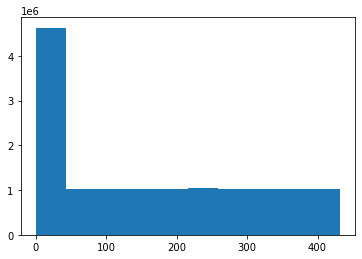

In [92]:
plt.hist(np.ndarray.flatten(return_months))

In [5]:
tmp_burned

NameError: name 'tmp_burned' is not defined

In [106]:
tmp_burned

<xarray.DataArray 'burnarea' (Y: 208, X: 155)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
    time     datetime64[ns] 1984-03-15

In [107]:
tmp_past.loc[thisY, thisX]

<xarray.DataArray 'burnarea' ()>
array(2)
Coordinates:
    X        float64 -1.269e+06
    Y        float64 1.510e+06

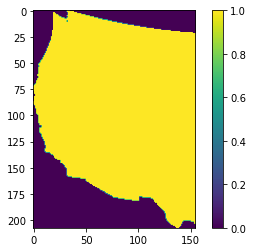

In [32]:
fig, ax = plt.subplots()
this = ax.imshow(tmp_burned)
fig.colorbar(this)

### Import Dependencies

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt
from ConvLSTM import ConvLSTM
from tqdm.notebook import tqdm
entire_sequence_version=True



# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import Data and Create Dataloaders

In [4]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate3d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # the output is the input sequence shift right by 1, both have length 19
    rand = np.random.randint(10,20)
    seq_len=batch.shape[2]
    return batch[:,:,0:seq_len-1], batch[:,:,1:seq_len]      

def collate2d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]

if entire_sequence_version:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)
else:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

### Visualize Data

In [5]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

### Instantiate Model, Optimizer and Loss

In [6]:
# The input video frames are grayscale, thus single channel
if entire_sequence_version:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=True).to(device)
else:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=False).to(device)
    

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

### Train for about 20 epochs

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(tqdm(train_loader)):
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))


Epoch:1 Training Loss:2236.41 Validation Loss:2138.27




Epoch:2 Training Loss:2093.28 Validation Loss:2056.14



### Visualize what our model has learned so far

In [9]:
### for 3d evaluation only 
if entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()[:,-1]>0.5)*255.0

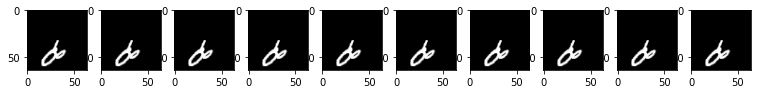

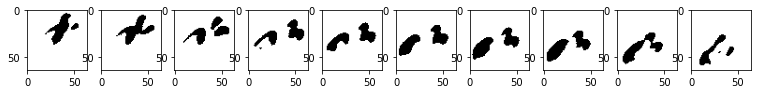

In [52]:
### for 3D evaluation only
if entire_sequence_version:
    seq_len=input.squeeze(1)[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(input.squeeze(1)[0][1].cpu().numpy() * 255, cmap='gray', vmin=0, vmax=255)

    seq_len=output[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(output[0][i], cmap='gray', vmin=0, vmax=255)

In [ ]:
### for 2d evaluation
if not entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [10]:
### for 2d evaluation
if not entire_sequence_version:
    for tgt, out in zip(target, output):       # Loop over samples

        # Write target video as gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, tgt, "GIF", fps = 5)    
            target_gif = gif.getvalue()

        # Write output video as gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, out, "GIF", fps = 5)    
            output_gif = gif.getvalue()

        display(HBox([widgets.Image(value=target_gif), 
                      widgets.Image(value=output_gif)]))